In [1]:
import os

ROOT_DATA = os.environ.get('LARD_DATA_ROOT_PATH')
ROOT_PROJECT = os.environ.get('LARD_YOLO_ROOT_PATH')

print(ROOT_DATA)
print(ROOT_PROJECT)

/home/yeli/yeli/data/lard
/home/yeli/Nextcloud/lard/yolov8


# 工具函数定义

In [2]:
import cv2
from matplotlib import pyplot as plt
import albumentations as A
import scienceplots
from datetime import datetime

plt.style.use('science')

BOX_COLOR = (255, 0, 0)  # Red
TEXT_COLOR = (255, 255, 255)  # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=20):
    """在图像上显示单个边界框"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(
        x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max),
                  color=color, thickness=thickness)

    fontScale = 3
    thickness = 5
    (text_width, text_height), _ = cv2.getTextSize(
        class_name,
        cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=fontScale, thickness=thickness
    )
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)),
                  (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=fontScale,
        thickness=thickness,
        color=TEXT_COLOR,
        lineType=cv2.LINE_AA,
    )
    return img


def visualize_detection(image, bboxes, category_ids, category_id_to_name):
    """可视化多个边界框的图像"""
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(6, 6), dpi=100)
    plt.axis('off')
    plt.imshow(img)
    plt.show()


def read_yolo_label(file_path, img_width, img_height):
    """
    读取YOLO格式的标签文件 并返回反归一化的bboxes和category_ids

    :param file_path: YOLO标签文件的路径
    :param img_width: 对应图像的实际宽度
    :param img_height: 对应图像的实际高度
    :return: 两个列表bboxes和category_ids
    """
    bboxes = []
    category_ids = []

    with open(file_path, 'r') as file:

        lines = file.readlines()

        for line in lines:
            record = line.strip().split()
            if len(record) < 5:
                continue

            # 类别编号
            category_ids.append(int(record[0]))

            # 归一化坐标
            center_x_n, center_y_n = float(record[1]), float(record[2])
            width_n, height_n = float(record[3]), float(record[4])
            x_min_n = (center_x_n - width_n / 2)
            y_min_n = (center_y_n - height_n / 2)

            # 反归一化
            x_min = x_min_n * img_width
            y_min = y_min_n * img_height
            width = width_n * img_width
            height = height_n * img_height

            bboxes.append([x_min, y_min, width, height])

    return bboxes, category_ids


# 类别字典
category_id_to_name = {0: 'runway'}

# 示例图片加载

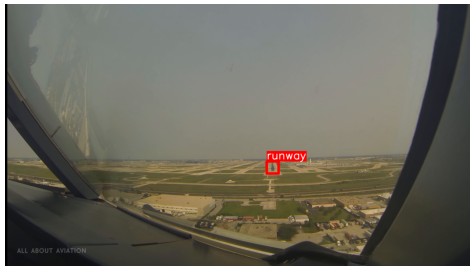

In [3]:
# 可视化一个样本
path_image = f'{ROOT_DATA}/YoloFormat/test_real_nominal/images/_lUpm8s55SA_082.png'
path_label = path_image.replace('images', 'labels').replace('.png', '.txt')

image = cv2.imread(path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes, category_ids = read_yolo_label(
    path_label,
    image.shape[1],
    image.shape[0]
)

visualize_detection(image, bboxes, category_ids, category_id_to_name)

# 复合变换

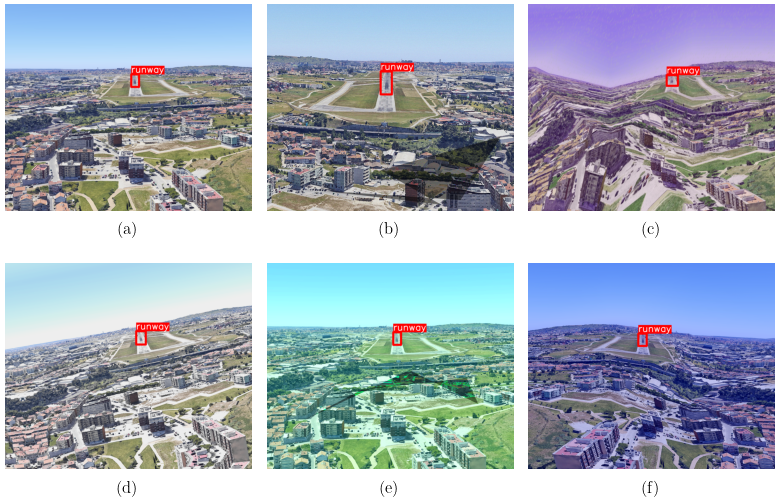

In [4]:
compose_transform = A.Compose(
    transforms=[
        # 常规变换
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625,
                           scale_limit=0.2, rotate_limit=30, p=0.5),
        A.GaussNoise(p=0.5),
        A.OneOf([
            A.MotionBlur(p=0.5),
            A.MedianBlur(blur_limit=3, p=0.5),
            A.Blur(blur_limit=3, p=0.5),
        ], p=0.5),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=0.1),
            A.PiecewiseAffine(p=0.3),
        ], p=0.5),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),
        ], p=0.5),
        A.HueSaturationValue(p=0.5),
        A.RGBShift(r_shift_limit=30, g_shift_limit=30,
                   b_shift_limit=30, p=0.5),
        A.RandomSizedBBoxSafeCrop(
            width=int(2448),
            height=int(2048),
            erosion_rate=0.3,
            p=0.5),

        # 天气变换
        A.OneOf([
            A.RandomRain(brightness_coefficient=0.9,
                         drop_width=1, blur_value=5, p=0.1),
            A.RandomSnow(brightness_coeff=1.5, snow_point_lower=0.1,
                         snow_point_upper=0.3, p=0.1),
            A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3,
                        alpha_coef=0.1, p=0.1),
            A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1,
                           shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1),
            A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5),
                             angle_lower=0.5, p=0.1),
        ], p=0.5),
    ],
    bbox_params=A.BboxParams(format='coco', label_fields=['category_ids']),
    p=1
)

# 读取图片和YOLO标签
path_image = f'{ROOT_DATA}/YoloFormat/train/images/LPPT_21_500_290.jpeg'
path_label = path_image.replace('images', 'labels').replace('.jpeg', '.txt')

image = cv2.imread(path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes, category_ids = read_yolo_label(
    path_label, image.shape[1], image.shape[0])

# 增强绘图
fig, axes = plt.subplots(2, 3, figsize=(8, 5.5), dpi=100)
axes = axes.flatten()
sub_titles = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# 绘制原图
img = image.copy()
for bbox, category_id in zip(bboxes, category_ids):
    class_name = category_id_to_name[category_id]
    img = visualize_bbox(img, bbox, class_name)
axes[0].imshow(img)
axes[0].axis('off')
axes[0].set_title(sub_titles[0], y=-0.15)

# 绘制其余增强图像
for ax, title in zip(axes[1:], sub_titles[1:]):

    transformed = compose_transform(
        image=image, bboxes=bboxes, category_ids=category_ids)

    img = transformed['image'].copy()
    for bbox, category_id in zip(transformed['bboxes'], transformed['category_ids']):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)

    ax.imshow(img)
    ax.set_title(title, y=-0.15)
    ax.axis('off')
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/augmentation_compose_{datetime.now().strftime("%Y%m%d_%H%M%S")}.jpg',
    dpi=600, bbox_inches='tight')
plt.show()

# 单次调用

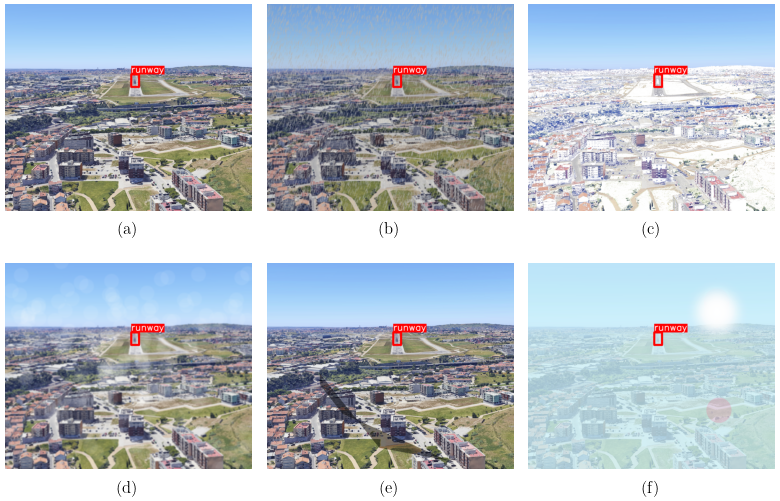

In [5]:
import cv2
from matplotlib import pyplot as plt
import albumentations as A

# 气象变换
transform_rain = A.Compose(
    [A.RandomRain(brightness_coefficient=0.9, drop_length=30,
                  drop_width=2, blur_value=10, p=1)],
    A.BboxParams(format='coco', label_fields=['category_ids']),
)
transform_snow = A.Compose(
    [A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.5,
                  snow_point_upper=0.7, p=1)],
    A.BboxParams(format='coco', label_fields=['category_ids']),
)
transform_fog = A.Compose(
    [A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3,
                 alpha_coef=0.45, p=1)],
    A.BboxParams(format='coco', label_fields=['category_ids']),
)
transform_shadow = A.Compose(
    [A.RandomShadow(num_shadows_lower=1, num_shadows_upper=3,
                    shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1)],
    A.BboxParams(format='coco', label_fields=['category_ids']),
)
transform_sunflare = A.Compose(
    [A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=1)],
    A.BboxParams(format='coco', label_fields=['category_ids']),
)
# 气象增强列表
transforms = [
    transform_rain, transform_snow,
    transform_fog, transform_shadow, transform_sunflare]

# 读取图片和标签
path_image = f'{ROOT_DATA}/YoloFormat/train/images/LPPT_21_500_290.jpeg'
path_label = path_image.replace('images', 'labels').replace('.jpeg', '.txt')

image = cv2.imread(path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes, category_ids = read_yolo_label(
    path_label, image.shape[1], image.shape[0])

# 气象增强说明绘图
fig, axes = plt.subplots(2, 3, figsize=(8, 5.5), dpi=100)

# 原始图像
img = image.copy()
for bbox, category_id in zip(bboxes, category_ids):
    class_name = category_id_to_name[category_id]
    img = visualize_bbox(img, bbox, class_name)
axes.flat[0].imshow(img)
axes.flat[0].axis('off')
axes.flat[0].set_title(sub_titles[0], y=-0.15)

# 绘制增强图像
for ax, title, transform in zip(axes.flat[1:], sub_titles[1:], transforms):

    transformed = transform(
        image=image, bboxes=bboxes, category_ids=category_ids)

    img = transformed['image'].copy()
    for bbox, category_id in zip(transformed['bboxes'], transformed['category_ids']):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)

    ax.imshow(img)
    ax.set_title(title, y=-0.15)
    ax.axis('off')
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig(
    f'{ROOT_PROJECT}/results/figs/eda/augmentation_weather{datetime.now().strftime("%Y%m%d_%H%M%S")}.jpg',
    dpi=600,  bbox_inches='tight')
plt.show()

# 持久化

In [1]:
import os
import cv2
import albumentations as A

imgsz = 640
prob = 1

# 定义变换
lard_transform = A.Compose(
    transforms=[

        # 色彩变换 噪声 图像质量等
        A.OneOf([
            A.RandomToneCurve(),
            # A.HueSaturationValue(p=0.1),  # v8已包含
            A.Solarize(threshold=245),
            A.Posterize(num_bits=7),
            A.Equalize(),
            A.RGBShift(),
            A.RandomBrightnessContrast(),
            A.GaussNoise(),
            A.ISONoise(),
            A.CLAHE(),
            A.ChannelShuffle(),
            A.InvertImg(),
            A.RandomGamma(),
            A.ToGray(),
            A.ToSepia(),
            A.Downscale(interpolation=cv2.INTER_LINEAR),
            A.MultiplicativeNoise(),
            A.FancyPCA(),
            A.ColorJitter(),
            A.Sharpen(),
            A.Emboss(),
            A.Superpixels(),
            A.RingingOvershoot(),
            A.UnsharpMask(),
            A.PixelDropout(),
            A.Spatter(mode=['rain', 'mud']),
        ], p=prob),

        # 图像质量
        A.OneOf([
            A.ImageCompression(quality_lower=30, quality_upper=90,
                               compression_type=A.ImageCompression.ImageCompressionType.JPEG),
            A.ImageCompression(quality_lower=30, quality_upper=90,
                               compression_type=A.ImageCompression.ImageCompressionType.WEBP),
        ], p=prob),

        # 模糊变换
        A.OneOf([
            A.Blur(),
            A.MotionBlur(),
            A.MedianBlur(),
            A.GaussianBlur(),
            A.GlassBlur(),
            A.AdvancedBlur(),
            A.Defocus(),
            A.ZoomBlur(),
        ], p=prob),

        # 几何变换
        A.OneOf([
            # A.ShiftScaleRotate(),  # v8已包含
            A.ElasticTransform(),
            A.Perspective(),
            A.Affine(),
            A.PiecewiseAffine(),
            A.VerticalFlip(),
            # A.HorizontalFlip(), # v8已包含
            A.Flip(),
            A.OpticalDistortion(),
            A.GridDistortion(),
            A.ChannelDropout(),
        ], p=prob),

        # 裁剪变换
        A.OneOf([
            A.RandomSizedBBoxSafeCrop(
                width=imgsz,
                height=imgsz,
                erosion_rate=0.3),
            A.CropAndPad(percent=(-0.1, 0.1)),
            A.RandomCropFromBorders(),
        ], p=prob),

        # 天气变换
        A.OneOf([

            A.RandomRain(brightness_coefficient=0.9, drop_length=30,
                         drop_width=2, blur_value=10),
            A.RandomSnow(brightness_coeff=2.5, snow_point_lower=0.3,
                         snow_point_upper=0.7),
            A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3,
                        alpha_coef=0.3),
            A.RandomShadow(num_shadows_lower=1, num_shadows_upper=2,
                           shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1)),
            A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5),
                             angle_lower=0.5),
        ], p=prob),

        # 重构
        A.Resize(height=imgsz, width=imgsz, p=1.0)
    ],
    bbox_params=A.BboxParams(format='yolo', label_fields=[
                             'class_labels']),  # label_fields需要符合yolov8要求
    p=0.2
)

# 持久化
ROOT_PROJECT = os.environ.get('LARD_YOLO_ROOT_PATH')
A.save(lard_transform, f'{ROOT_PROJECT}/datasets/cfg/lard_transform.json')
lard_transform_loaded = A.load(
    f'{ROOT_PROJECT}/datasets/cfg/lard_transform.json')

# 测试



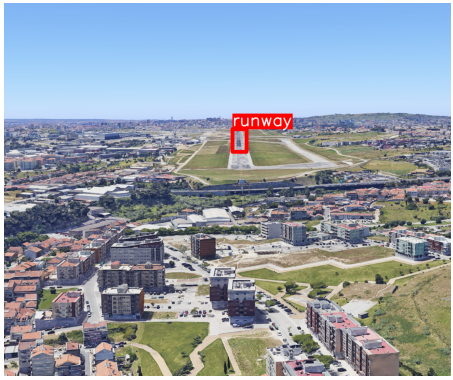

(2048, 2448, 3)


In [9]:
import cv2
from matplotlib import pyplot as plt
import albumentations as A

# https://blog.csdn.net/qq_39735236/article/details/127655509

trans = A.RingingOvershoot(p=1)
transform = A.Compose(
    [],
    A.BboxParams(format='coco', label_fields=['category_ids']),
    p=1
)
# 读取图片和标签
path_image = f'{ROOT_DATA}/YoloFormat/train/images/LPPT_21_500_290.jpeg'
path_label = path_image.replace('images', 'labels').replace('.jpeg', '.txt')

image = cv2.imread(path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes, category_ids = read_yolo_label(
    path_label, image.shape[1], image.shape[0])

transformed = transform(
    image=image, bboxes=bboxes, category_ids=category_ids)

img = transformed['image'].copy()
for bbox, category_id in zip(transformed['bboxes'], transformed['category_ids']):
    class_name = category_id_to_name[category_id]
    img = visualize_bbox(img, bbox, class_name)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()
print(img.shape)

In [ ]:
import cv2
from matplotlib import pyplot as plt
import albumentations as A

# https://blog.csdn.net/qq_39735236/article/details/127655509


transform = A.Compose(
    [],
    A.BboxParams(format='coco', label_fields=['category_ids']),
    p=1
)
# 读取图片和标签
path_image = f'{ROOT_DATA}/YoloFormat/train/images/LPPT_21_500_290.jpeg'
path_label = path_image.replace('images', 'labels').replace('.jpeg', '.txt')

image = cv2.imread(path_image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes, category_ids = read_yolo_label(
    path_label, image.shape[1], image.shape[0])

transformed = transform(
    image=image, bboxes=bboxes, category_ids=category_ids)

img = transformed['image'].copy()
for bbox, category_id in zip(transformed['bboxes'], transformed['category_ids']):
    class_name = category_id_to_name[category_id]
    img = visualize_bbox(img, bbox, class_name)

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()
print(img.shape)